# Organizing, Subsetting and Processing Data

Now that you've successfully downloaded the GRACE and GLDAS data, you will need to read in and process the data to get groundwater anamoly estimates. Both datasets have raw data contained in .nc or .nc4 files. These are files for storing multi-dimensional data--in our case, the key dimensions we are interested in are latittude and longitude (geography) and time. We can use the `xarray` package to read in these data. 

## Reading in GRACE and GLDAS Data

Both datasets have similar processes for loading in the data which are outlined in detail below. However, the first step for processing both datasets is to filter to your region of interest. This is important because it makes processing times for each step much quicker. As such, our first step in processing will be loading in a shapefile and filtering to the region of interest before loading in GRACE and GLDAS and merging them with other datasets. 

### Subsetting The Data 

For most use cases, it will make the most sense to load in a shapefile and use this file to narrow down your region. This will allow your analysis to focus on your area of interest as precisely as possible and improve the efficiency of your code. If you don't have a shapefile or know your region of interest, you can pick any 4 latitude/longitude points and use them to draw a rectangle around a region of the world you are interested in. You can also skip this step, but note it will make the code take much longer to run. 

For our analysis here, we will use a shapefile that focuses on the Colorado River Basin. 

#### What is a Shapefile? 

A shapefile is a file that stores geometric location and attribute information of geographical features in a nontopological way. Shapefiles represent geographical features by points, lines, or polygons (geographical areas) (ArcGIS). It is one of the simpler ways to store and work with geographic data. Many shapefiles are publicly available for download by government agencies, researchers, or practitioners. Below is an example of what a shapefile looks like in tabular form and how you can go from that to a map.

<img src='images/shape%20file%20figure.png'>
Source: ReStore

#### Applying This Method to the CRB 

Below, we use this method to use a shapefile of the Colorado River Basin for analysis. You can download the shape file for the Colorado River Basin from ArcGIS hub [here](https://coloradoriverbasin-lincolninstitute.hub.arcgis.com/datasets/a198d1658b7741618e7d3732726cbc8f_0/explore?location=37.047204%2C-110.573590%2C6.53). After downloading the shapefiles, remember to **move them to the `data/shapefiles` folder** to run the code to read the shapefile. A visual of this is shown below: 

<img src='images/CRB_shapefile.png'>

To work with shapefiles, we will use the `geopandas` package, a spatial analysis package built on top of `pandas`. We will begin by loading in this package and reading in the shapefile. Next, we will load in plotting functions from `matplotlib` and map the shapefile. 

#### Dependencies

In [29]:
# import necessary packages and libraries 
# they had a bug - submit Github issue - had import numpy as pd 
import geopandas as gpd 
from shapely.geometry import box
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np
import xarray as xr
import numpy as np
import os 
from datetime import datetime
import requests

#### Key variables

In [2]:
# Earth's radius
EARTH_RADIUS_KM = 6371
# Centimeters to kilometers
CM_TO_KM_RATIO = 1e-5
# Here, input the file path to the base data directory
BASE_DIR = '/Users/npovejsil/Downloads/DSSG2023-Groundwater/'
# Figure size
FIG_SIZE = (10, 10)

In [3]:
# Common functions

def add_labels(ax, title):
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_title(title);

#### Loading in a shapefile

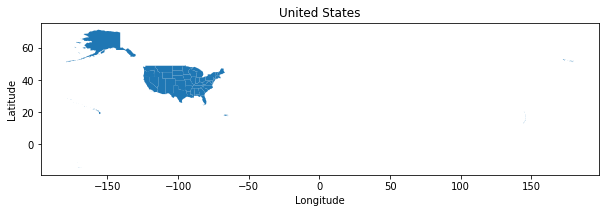

In [4]:
# Read the shapefile
usa_shapefile = gpd.read_file(os.path.join(BASE_DIR, "data/shapefiles/tl_2017_us_state/tl_2017_us_state.shp"))

# Plot of entire Colorado River Basin
fig, ax = plt.subplots(figsize=FIG_SIZE)
usa_shapefile.plot(ax=ax)
add_labels(ax, 'United States')

A simple way to start narrowing down to the area within the Colorado River Basin is to construct a rectangle around the region and only read and process rows within that rectangle.

Below, we provide code to construct a bounding rectangle

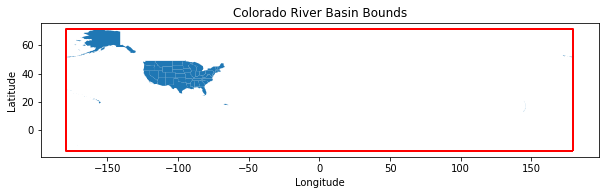

In [5]:
# Here, we use geopandas.GeoSeries.total_bounds
[lon_min, lat_min, lon_max, lat_max] = usa_shapefile.total_bounds

# Here, we visualize the bounding box
# First, we create a GeoDataFrame with a single rectangle geometry
bounding_box = gpd.GeoDataFrame(geometry=[box(lon_min, lat_min, lon_max, lat_max)])
# Then, we plot both the basin shapefile and the bounding_box
fig, ax = plt.subplots(figsize=FIG_SIZE)
usa_shapefile.plot(ax=ax)
bounding_box.plot(ax=ax, facecolor='none', edgecolor='red', linewidth=2)

add_labels(ax, 'Colorado River Basin Bounds')


As you can see from the above plot, a substantial amount of geography not within the CRB is included within the bounding rectangle. 

Later on, we will use spatial processes to eliminate extraneous areas from our dataset. For now however, using the bounding ectangle will greatly speed up reading and applying other transformations to the data. 

#### Working with GRACE data

A single `.nc` file provides us with global land GRACE MASCON data. 

We will start by using `xarray` to read in the data. 

In [6]:
# Here, we load in GRACE data.
grace = xr.open_dataset(os.path.join(BASE_DIR, "scripts/data/TELLUS_GRAC-GRFO_MASCON_CRI_GRID_RL06.1_V3/GRCTellus.JPL.200204_202402.GLO.RL06.1M.MSCNv03CRI.nc"))

# print out grace data. Our varibale of interest (lwe_thickness) is measured in centimeters 
grace

<xarray.Dataset> Size: 1GB
Dimensions:        (lon: 720, lat: 360, time: 230, bounds: 2)
Coordinates:
  * lon            (lon) float64 6kB 0.25 0.75 1.25 1.75 ... 358.8 359.2 359.8
  * lat            (lat) float64 3kB -89.75 -89.25 -88.75 ... 88.75 89.25 89.75
  * time           (time) datetime64[ns] 2kB 2002-04-17T12:00:00 ... 2024-02-...
Dimensions without coordinates: bounds
Data variables:
    lwe_thickness  (time, lat, lon) float64 477MB ...
    uncertainty    (time, lat, lon) float64 477MB ...
    lat_bounds     (lat, bounds) float64 6kB ...
    lon_bounds     (lon, bounds) float64 12kB ...
    time_bounds    (time, bounds) datetime64[ns] 4kB ...
    land_mask      (lat, lon) float64 2MB ...
    scale_factor   (lat, lon) float64 2MB ...
    mascon_ID      (lat, lon) float64 2MB ...
    GAD            (time, lat, lon) float64 477MB ...
Attributes: (12/53)
    Conventions:                   CF-1.6, ACDD-1.3, ISO 8601
    Metadata_Conventions:          Unidata Dataset Discovery v1.0
    standard_name_vocabulary:      NetCDF Climate and Forecast (CF) Metadata ...
    title:                         JPL GRACE and GRACE-FO MASCON RL06.1Mv03 CRI
    summary:                       Monthly gravity solutions from GRACE and G...
    keywords:                      Solid Earth, Geodetics/Gravity, Gravity, l...
    ...                            ...
    C_30_substitution:             TN-14; Loomis et al., 2019, Geophys. Res. ...
    user_note_1:                   The accelerometer on the GRACE-B spacecraf...
    user_note_2:                   The accelerometer on the GRACE-D spacecraf...
    journal_reference:             Watkins, M. M., D. N. Wiese, D.-N. Yuan, C...
    CRI_filter_journal_reference:  Wiese, D. N., F. W. Landerer, and M. M. Wa...
    date_created:                  2024-04-25T02:04:21Z

The first thing you will note is that the dataset has several dimensions: `lon`, `lat`, `time`, and `bounds`. These dimensions exist because the GRACE data come at the pixel-level for each year. In this situation, a pixel is the smallest geographic unit of analysis. Because collecting and processing GRACE satellite data is technical and computationally expensive, GRACE measurements are given as .5-degree by .5-degree squares. The pixels cover Earth's entire surface and each have a GRACE measurement monthly from 2002-present. A visual of this is shown below, where each square in the GRID corresponds to a pixel (Sharma, Patnaik, Biswal, Reager, 2020). Note that the yellow dots are gauging stations for comparison. 

<p align="center">
    <img src="images/GRACE_grids.png" width="500" />
</p>

We begin by transforming the dataset into a pandas dataframe. For efficiency, select only the variables we need. Additionally, to aid working with other datasets, we will transform the longitude points from a [0,360] range to a [-180,180] range.  

Remember that each latitude and longitude serves as the center of a pixel. Any associated values are not representative of this exact point in space, but rather the entire pixel that the point is a center of. 

Though not necessary for our analysis, if one wanted to get the coordinates of each of the four corners, they would just have to add and subtract the pixel length divided by 2 to each latitude and longitude value. 

In [7]:
# A function that converts longitude from 0-360 to -180-180
def convert_longitude(lon):
    if lon >= 180:
        return lon - 360
    else:
        return lon

In [8]:
# Only extracting the variables we need from the grace dataset, after which we convert everything into a dataframe.
grace_df = grace[['lon','lat','time','lwe_thickness','uncertainty','scale_factor']].to_dataframe()
# Expanding the entries (i.e., every lon lat combo has multiple times, thicknesses, and uncertainties, which we would like to be unique rows)
grace_df.reset_index(inplace=True)
# Relabel the columns to include units
grace_df = grace_df.rename(columns={'lwe_thickness': 'lwe_thickness_cm', 'uncertainty': 'uncertainty_cm'})
# Convert longitude values
grace_df['lon'] = grace_df['lon'].apply(convert_longitude)
# How many duplicates exist?
"There are %s duplicate rows" % grace_df.duplicated().sum()
# Next, we subset the data to only include pixels within the bounding rectangle
grace_df = grace_df[(grace_df.lon > lon_min) & (grace_df.lon < lon_max) & (grace_df.lat > lat_min) & (grace_df.lat < lat_max)]
# Finally, we sort using the time column
grace_df.sort_values(by='time', inplace=True)


In [9]:
grace_df

,lon,lat,time,lwe_thickness_cm,uncertainty_cm,scale_factor
34730,0.25,-14.25,2002-04-17 12:00:00,-1.485243,1.512199,NaN
33817820,-155.75,-12.75,2002-04-17 12:00:00,-1.731247,0.970700,NaN
18171380,109.75,-6.75,2002-04-17 12:00:00,-0.541967,12.938483,NaN
30105160,-178.25,16.25,2002-04-17 12:00:00,-0.964372,2.978175,NaN
26034850,157.25,-12.25,2002-04-17 12:00:00,-2.233941,1.992177,NaN
...,...,...,...,...,...,...
39638199,-120.75,39.75,2024-02-15 12:00:00,-1.208476,13.952510,0.918804
39638429,-120.75,40.25,2024-02-15 12:00:00,-1.208476,13.952510,0.904416
39638659,-120.75,40.75,2024-02-15 12:00:00,9.323663,5.247161,1.159689
39476739,-121.75,48.75,2024-02-15 12:00:00,-19.969018,7.961481,2.027458


#### Scaling and unit conversion

The last step in processing GRACE data is to multiply `lwe_thickness` by a scale factor and convert the units. 

The scale factors are intended to restore much of the energy that is removed due the sampling and post-processing of GRACE observations. More information about the scaling factors can be found [here](https://grace.jpl.nasa.gov/data/get-data/monthly-mass-grids-land/). **Note that NASA states users should multiply the data by the scaling coefficient, so it is imperative not to skip this step**. 

The original terrestrial water storage is measured in $cm$.  We convert those measurements to $km^3$ by:

1. Transforming terrestrial water storage units from $cm$ to $km$ by multiplying the reported value by the `CM_TO_KM_RATIO`. 
2. Multiplying the resulting $km$ value by the *surface area* of each pixel (in $km^2$).

We multiply the converted value by the `scale_factor` provided for each pixel. 

In the following code, we also convert the unit of uncertainty from $cm$ to $km^3$. We document how to incorporate uncertainty on the [Understanding Uncertainty in Groundwater Calculation](./06-Understanding%20Uncertainty.md) page.

In [10]:
# Compute surface area for pixel with dimensions n x n degree. Note the area of a pixel changes with respect to latitude!
degree_measure = 0.5
grace_df['surface_area_km2'] = EARTH_RADIUS_KM * np.radians(degree_measure) * EARTH_RADIUS_KM * np.radians(degree_measure) * np.cos(np.radians(grace_df['lat']))

# Convert units from cm to km^3
grace_df["lwe_thickness_km3"] = grace_df["lwe_thickness_cm"]  * CM_TO_KM_RATIO * grace_df['surface_area_km2'] * grace_df['scale_factor']
grace_df['uncertainty_km3'] = grace_df["uncertainty_cm"] * CM_TO_KM_RATIO * grace_df['surface_area_km2']

### GLDAS Data 

Next, we will read in the GLDAS data which provides us with information on snow pack and soil moisture. These data are similarly in a multidimensional data format which can be read in using `xarray`. However, the data come in individual files that require being read in and combined into one dataset. The code below does this. 

In [11]:
# Read in one file of the GLDAS data as a demonstration
# Note the interested variables "SWE_inst" and "RootMoist_inst" are measured in kilogram per square meter (kg/m2)

xr.open_dataset(os.path.join(BASE_DIR, "scripts/data/GLDAS_data/GLDAS_NOAH025_M.A200001.021.nc4"))

<xarray.Dataset> Size: 124MB
Dimensions:                (time: 1, bnds: 2, lon: 1440, lat: 600)
Coordinates:
  * time                   (time) datetime64[ns] 8B 2000-01-01
  * lon                    (lon) float32 6kB -179.9 -179.6 ... 179.6 179.9
  * lat                    (lat) float32 2kB -59.88 -59.62 ... 89.62 89.88
Dimensions without coordinates: bnds
Data variables: (12/37)
    time_bnds              (time, bnds) datetime64[ns] 16B ...
    Swnet_tavg             (time, lat, lon) float32 3MB ...
    Lwnet_tavg             (time, lat, lon) float32 3MB ...
    Qle_tavg               (time, lat, lon) float32 3MB ...
    Qh_tavg                (time, lat, lon) float32 3MB ...
    Qg_tavg                (time, lat, lon) float32 3MB ...
    ...                     ...
    Rainf_f_tavg           (time, lat, lon) float32 3MB ...
    Tair_f_inst            (time, lat, lon) float32 3MB ...
    Qair_f_inst            (time, lat, lon) float32 3MB ...
    Psurf_f_inst           (time, lat, lon) float32 3MB ...
    SWdown_f_tavg          (time, lat, lon) float32 3MB ...
    LWdown_f_tavg          (time, lat, lon) float32 3MB ...
Attributes: (12/19)
    CDI:                    Climate Data Interface version 1.9.8 (https://mpi...
    Conventions:            CF-1.6
    history:                created on date: 2019-09-17T14:58:21.836
    source:                 Noah_v3.6 forced with GDAS-AGRMET-GPCPv13rA1
    institution:            NASA GSFC
    missing_value:          -9999.0
    ...                     ...
    MAP_PROJECTION:         EQUIDISTANT CYLINDRICAL
    SOUTH_WEST_CORNER_LAT:  -59.875
    SOUTH_WEST_CORNER_LON:  -179.875
    DX:                     0.25
    DY:                     0.25
    CDO:                    Climate Data Operators version 1.9.8 (https://mpi...

In [12]:
### import GLDAS data, filter to CRB, combine into one dataframe 

gldas_path = os.path.join(BASE_DIR, "scripts/data/GLDAS_Data/")


gldas_df = pd.DataFrame()

#Iterating through files in path
for filename in os.listdir(gldas_path):
    
    if filename.endswith(".nc4"):
        
        #Reading in data as xarray then converting to DataFrame
        xd = xr.open_dataset(gldas_path+str(filename))
        xd_df = xd.to_dataframe()

        xd_df.reset_index(inplace=True)

        xd_df = xd_df[(xd_df.lon> lon_min) & (xd_df.lon < lon_max)]
        xd_df = xd_df[(xd_df.lat> lat_min) & (xd_df.lat < lat_max)]

        #Extracting only needed columns 
        df_slice = xd_df[["time", "lon", "lat", "SWE_inst", "RootMoist_inst"]]
        df_slice = df_slice.drop_duplicates()

        gldas_df = pd.concat([gldas_df, df_slice], axis=0)

gldas_df = gldas_df.rename(columns={'SWE_inst': 'SWE_inst_kg/m2', 'RootMoist_inst': 'RootMoist_inst_kg/m2'})

In the following code, we are changing the units of Soil Moisture and Snow Water Equivalent to kilometer cubed. The two variables are originally measured in kg/m2.

We convert the unit to kimoleter cubed by:
1. multiply each data point by 1,000,000 to convert the data point in kg/km2
2. multiply each data point by the surface area of each pixel measured in kilometer squared to get the two variables measured in kilograms
3. At standard temperature and pressure, water has density of 1 kg/Liter. So 1 kg water = 1 Liter = 1e-12 kilometer cubed. We multiply the data by (1e-12) to get the data in kilometer cubed

In [13]:
# Compute surface area for pixel with dimension 0.25 x 0.25 degree. 
gldas_df['surface_area_km2_0.25'] = EARTH_RADIUS_KM * np.radians(.25) * EARTH_RADIUS_KM * np.radians(.25) * np.cos(np.radians(gldas_df['lat']))

# Converting units from kg/m2 to km3
KG_PER_M2_TO_KG_PER_KM2_RATIO = 1e6
KG_TO_KM3_RATIO = 1e-12


gldas_df['RootMoist_inst_km3'] = gldas_df['RootMoist_inst_kg/m2'] * KG_PER_M2_TO_KG_PER_KM2_RATIO * gldas_df['surface_area_km2_0.25'] * KG_TO_KM3_RATIO
gldas_df['SWE_inst_km3'] = gldas_df['SWE_inst_kg/m2'] * KG_PER_M2_TO_KG_PER_KM2_RATIO * gldas_df['surface_area_km2_0.25'] * KG_TO_KM3_RATIO
gldas_df

,time,lon,lat,SWE_inst_kg/m2,RootMoist_inst_kg/m2,surface_area_km2_0.25,RootMoist_inst_km3,SWE_inst_km3
1982,2004-12-01,-179.125,-14.375,NaN,NaN,748.575256,NaN,NaN
1983,2004-12-01,-179.125,-14.125,NaN,NaN,749.405273,NaN,NaN
1984,2004-12-01,-179.125,-13.875,NaN,NaN,750.221008,NaN,NaN
1985,2004-12-01,-179.125,-13.625,NaN,NaN,751.022461,NaN,NaN
1986,2004-12-01,-179.125,-13.375,NaN,NaN,751.809570,NaN,NaN
...,...,...,...,...,...,...,...,...
863321,2012-09-01,179.625,70.375,NaN,NaN,259.544403,NaN,NaN
863322,2012-09-01,179.625,70.625,NaN,NaN,256.365967,NaN,NaN
863323,2012-09-01,179.625,70.875,NaN,NaN,253.182587,NaN,NaN
863324,2012-09-01,179.625,71.125,9.361667,269.733185,249.994476,0.067432,0.002340


### Focusing on the Basin 

Returning to the GRACE data, we saw earlier that though the data is filtered down to a rectangle containing the Colorado River Basin, there are still areas that are not contained in the rectangle. We can use geoprocessing techniques from `geopandas` to keep points in GRACE that only intersect the shape file. 

In [14]:
# Create a GeoDataFrame directly from grace_df
grace_gdf = gpd.GeoDataFrame(grace_df, 
                              crs='epsg:4326',
                              geometry=gpd.points_from_xy(grace_df['lon'], grace_df['lat']))

# Ensure the CRS for basin_shapefile is set correctly
usa_shapefile.crs = "EPSG:4326"

# Use sjoin to find points that intersect with the shapefile
intersected = gpd.sjoin(grace_gdf, usa_shapefile, how="inner", predicate="intersects")

# Select the columns we are interested in
# grace_df = intersected[['lon', 'lat', 'time', 'lwe_thickness_cm', 'uncertainty_cm', 'scale_factor', 'surface_area_km2','lwe_thickness_km3', 'uncertainty_km3']]

In [15]:
grace_df = intersected[['lon', 'lat', 'time', 'lwe_thickness_cm', 'uncertainty_cm', 'scale_factor', 'surface_area_km2','lwe_thickness_km3', 'uncertainty_km3']]

In [16]:
grace_df.head()

,lon,lat,time,lwe_thickness_cm,uncertainty_cm,scale_factor,surface_area_km2,lwe_thickness_km3,uncertainty_km3
40049440,-118.25,34.25,2002-04-17 12:00:00,-2.535703,5.889548,1.296149,2555.053329,-0.083976,0.150481
40049670,-118.25,34.75,2002-04-17 12:00:00,-1.469398,6.981447,1.926436,2539.774714,-0.071893,0.177313
40049210,-118.25,33.75,2002-04-17 12:00:00,-0.857481,5.889548,NaN,2570.137366,NaN,0.151369
33772970,-156.25,69.75,2002-04-17 12:00:00,4.151969,5.409994,0.923236,1069.874796,0.041011,0.057880
33773200,-156.25,70.25,2002-04-17 12:00:00,4.151969,5.409994,0.585195,1044.526908,0.025379,0.056509


##### Upsampling GRACE

One key consideration for combining GRACE and GLDAS data is that pixels in GRACE data are .5°x.5° while GLDAS data has .25°x.25° pixels. One way to handle this without loss of data is to "upscale" GRACE data to make it mergable with GLDAS. That is, transform the GRACE data pixels from .5°x.5° to .25°x.25°. That is, we transform the GRACE data pixels from a granularity of .5°x.5° to one of .25°x.25°. This process yields a four points for each original point.

One way we can do this is to "upsample" GRACE data. This is shown visually below: 

<p align="center">
    <img src="images/upscale.png" width="500" />
</p>

After upsampling, you are left witha final product of evenly-spaced, non-overlapping $.25°x.25°$ pixels (shown below, far right panel). 

<p align="center">
    <img src="images/upscalingviz.png" width="1200" />
</p>

Each "pixel" thus represents a chunk of land approximately 235.46 miles squared ($\approx$ 378.94 kilometers squared). A visualization of an individual pixel is shown below.

<p align="center">
    <img src="images/lon-lat.png" width="500" />
</p>

In [17]:
# Helper function to generate the upsampled GRACE data
def upsample_point(row):
    # For the row of GRACE dataframe inputted in the function, we first store the time, lon, lat, lwe_thickness, and uncertainty value
    t = row['time']
    x = row['lon']
    y = row['lat']
    lwe = row['lwe_thickness_km3']
    uncertainty = row['uncertainty_km3']
    
    # Create upscaled longitude values (by creating a distance of 0.125 on each side of the
    # original longitude (x), you obtain a total length of 0.25 around each original point)
    xx = [round(x-0.125,3), round(x+0.125,3)]

    # Create upscaled latitude values (by creating a distance of 0.125 on each side of the
    # 0riginal latitude (y), you obtain a total length of 0.25 around each original point)
    yy = [round(y-0.125,3), round(y+0.125,3)]
    
    # Returning a list of upsampled points for the row inputted, notice the lwe_thickness and the uncertainty value stay the same
    return [
        {"time": t, "lon": xx[0], "lat": yy[0], "lwe_thickness_km3": lwe, 'uncertainty_km3': uncertainty},
        {"time": t, "lon": xx[0], "lat": yy[1], "lwe_thickness_km3": lwe, 'uncertainty_km3': uncertainty},
        {"time": t, "lon": xx[1], "lat": yy[0], "lwe_thickness_km3": lwe, 'uncertainty_km3': uncertainty},
        {"time": t, "lon": xx[1], "lat": yy[1], "lwe_thickness_km3": lwe, 'uncertainty_km3': uncertainty}
    ]

# Loop over each row in the GRACE dataframe and perform the helper function to generate a list of upsampled points
upsampled_points = [record for _, row in grace_df.iterrows() for record in upsample_point(row)]

# Convert the list of upsampled points into a DataFrame
upsampled_grace_df = pd.DataFrame(upsampled_points)


#### Edge Pixels

The edges of the basin often do not completely intersect with a pixel. For example, in the figure below, each square on the graph is a 5°x.5° square. As you can see, within the center of the basin, there is perfect overlap between several pixels and the basin. However, when you get to the outer edges of the basin, you can see that there is not perfect overlap with a pixel. The basin only covers part of a pixel around the edges. 

For our analysis, we only include a pixel in calculating groundwater anamolies if the center of the pixel is contained within the basin. This will generally include pixels that have a majority of their area within the basin and exclude pixels that do not. Additionally, since the Colorado River Basin is so large, the effect of edge cases on our calculations will be small. However, if you plan to analyze the region within a smaller basin, one strategy to account for this is to use an area weighting average of the pixel with the basin. This will allow you to weight your values by the area that intersects both the pixel and the basin. 

<Figure size 720x720 with 0 Axes>

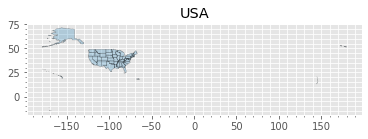

In [18]:
# Plot of entire Colorado River Basin
plt.style.use('ggplot')
plt.figure(figsize=[10,10])
usa_shapefile.plot(alpha=.3, edgecolors='black')
plt.title("USA")
plt.grid(which="minor")
plt.minorticks_on()
plt.show()

### Merging the Datasets 

Now that GRACE and GLDAS are in standardized, tabular formats, we can merge these datasets together to combine all the variables of interest and calculate groundwater estimates. Note that since the GRACE data is already filtered to the area of interest, we can simply perform a left join to merge GLDAS with GRACE data. 

In [19]:
# Standardize times in both datasets and do a left join 
upsampled_grace_df['time'] = pd.to_datetime(upsampled_grace_df["time"].astype(str).str.slice(0, 7), format='%Y-%m')
gldas_df['time'] = pd.to_datetime(gldas_df["time"].astype(str).str.slice(0, 7), format='%Y-%m')

grace_gldas_df = upsampled_grace_df.merge(gldas_df, on=["time", "lat", "lon"], how="left")

### Calculating Anamolies 

In order to compute groundwater anamolies, you need to compute the deviation from the mean for each measurement:

$$d_i = p_i - \mu$$

where ($d_i$) is the deviation from the mean for obervation i, ($p_i$) is the measurement for observation i, and $\mu$ is the average over the specified time period. 

In order to calculate $\mu$, you take the average for each water category over a specified time period. Here, we use the time period from 2004-2009, following NASA and recent literature, which is shown in code below. Note that the code is easily modifiable if you would like to focus on a different time period. 


In [20]:
grace_gldas_df

,time,lon,lat,lwe_thickness_km3,uncertainty_km3,SWE_inst_kg/m2,RootMoist_inst_kg/m2,surface_area_km2_0.25,RootMoist_inst_km3,SWE_inst_km3
0,2002-04-01,-118.375,34.125,-0.083976,0.150481,0.000000,21.136366,639.710632,0.013521,0.000000e+00
1,2002-04-01,-118.375,34.375,-0.083976,0.150481,0.000000,98.666733,637.812988,0.062931,0.000000e+00
2,2002-04-01,-118.125,34.125,-0.083976,0.150481,0.000000,29.302471,639.710632,0.018745,0.000000e+00
3,2002-04-01,-118.125,34.375,-0.083976,0.150481,0.000083,127.034538,637.812988,0.081024,5.315108e-08
4,2002-04-01,-118.375,34.625,-0.071893,0.177313,0.000000,162.355515,635.903137,0.103242,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...
4316635,2024-02-01,-120.625,40.875,0.253197,0.122872,NaN,NaN,NaN,NaN,NaN
4316636,2024-02-01,-121.875,48.625,-0.825148,0.162262,NaN,NaN,NaN,NaN,NaN
4316637,2024-02-01,-121.875,48.875,-0.825148,0.162262,NaN,NaN,NaN,NaN,NaN
4316638,2024-02-01,-121.625,48.625,-0.825148,0.162262,NaN,NaN,NaN,NaN,NaN


In [21]:
grace_gldas_df.to_csv('grace_gldas.csv', index=False)

In [23]:
# Filter the dataframe to include only the required dates to calculate average
#Total ground water storage 
#rate of change for most recent five years, pull data for 6 bc 5 change points/differences (each year)
TIME_PERIOD_START = '2004-01-01'
TIME_PERIOD_END = '2009-12-31'

mask = (grace_gldas_df['time'] >= TIME_PERIOD_START) & (grace_gldas_df['time'] <= TIME_PERIOD_END)
filtered_df = grace_gldas_df.loc[mask]

# Group by lat and lon and calculate average storage for the specified date range
average_df = filtered_df.groupby(['lat','lon']).agg({'SWE_inst_km3':'mean', 'RootMoist_inst_km3':'mean'}).reset_index()
average_df = average_df.rename(columns={'SWE_inst_km3':'SWE_mean_km3', 'RootMoist_inst_km3':'RootMoist_mean_km3'})

grace_gldas_df = grace_gldas_df.merge(average_df, on=['lat','lon'], how='left')

# Compute the anomaly for soil moisture and snow water equivalent
grace_gldas_df['SWE_anomaly_km3'] = grace_gldas_df['SWE_inst_km3'] - grace_gldas_df['SWE_mean_km3']
grace_gldas_df['RM_anomaly_km3'] = grace_gldas_df['RootMoist_inst_km3'] - grace_gldas_df['RootMoist_mean_km3']

KeyError: 'SWE_mean_km3'

If you want to compute the mean of another time period, you would need to:
1. multiply each GRACE data point by the mean of GRACE for that pixel from the time period 2004 to 2009
2. calculate the mean of GRACE for the time period you want for every pixel
3. subtract each GRACE observation by its mean for the new pixel

Step 2 and 3 are similar to the code chunk above where we calculated the anomaly for Snow Water Equivalent and Soil Moisture

## Getting USGS Data

In [33]:
# Loading necessary packages
import csv
import numpy as np
import pandas as pd

# Packages to select data inside the basin
import geopandas as gpd
from shapely.geometry import Point

# Packages to scrape website
import requests
from io import StringIO
from requests.exceptions import RequestException
from urllib3.util.retry import Retry
from requests.adapters import HTTPAdapter
from datetime import date
from datetime import timedelta

# Package to compare potentially repetitive data
from fuzzywuzzy import fuzz

# Packages for visualization
import matplotlib.pyplot as plt
from bokeh.models import HoverTool, ColumnDataSource
from bokeh.plotting import figure, show, output_notebook
from bokeh.tile_providers import get_provider, Vendors
from bokeh.palettes import Category10, Category20
import itertools

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [34]:
# Below is the function designed to scrape the necessary information about all the monitoring sites in the Colorado River Basin as maintained by the USGS
def read_usgs_monitoring_sites(url):
    
    response = requests.get(url)
    file_content = response.text

    # Get the line number where data starts
    start_pos = file_content.find("site_no\tstation_nm\tsite_tp_cd\tdec_lat_va\tdec_long_va\tcoord_acy_cd\tdec_coord_datum_cd")

    # Extract data from start line till end
    data_content = file_content[start_pos:]

    # Create a pandas dataframe
    df = pd.read_csv(StringIO(data_content), delimiter='\t')
    df = df.drop(0)

    # Select only the columns of interest
    df = df[['dec_lat_va', 'dec_long_va','station_nm','site_no']]
    df['station_nm'] = df['station_nm'].str.title()
    df = df.rename(columns={'site_no':'site_id', 'station_nm':'name', 'dec_lat_va':'lat', 'dec_long_va':'lon'})

    return df

In [35]:
#EDITED VERSION 
def read_usgs_storage(url):
    response = requests.get(url)
    file_content = response.text

    # Get the line number where data starts
    start_pos = file_content.find("agency_cd\tsite_no\tdatetime\t")

    # Check if the start position is found
    if start_pos == -1:
        print(f"No data found in the response from {url}")
        return None

    # Extract data from start line till end
    data_content = file_content[start_pos:]

    try:
        # Create a pandas dataframe
        df = pd.read_csv(StringIO(data_content), delimiter='\t', comment='#', na_values=['', ' ', 'NA', 'nan'])
        
        # Drop rows where all elements are NaN
        df = df.dropna(how='all')

        # Drop any unnecessary rows (like headers repeated in the middle of the file)
        df = df[df['datetime'].str.match(r'\d{4}-\d{2}-\d{2} \d{2}:\d{2}', na=False)]

    except pd.errors.EmptyDataError:
        # No data to parse from the file, return None
        return None
    except pd.errors.ParserError as e:
        print(f"Parser error for {url}: {e}")
        return None

    # Extract columns of the format 'ddddd_00054_ddddd' (any length of d, d stands for digits)
    pattern = r'^\d+_00054_\d+$'  # regex pattern to match the desired column format
    matched_columns = df.filter(regex=pattern).columns

    # Define the order of columns to prioritize
    column_order = ['00003', '32400', '30800', '00011']

    # Select the first column that exists in the DataFrame according to your order
    for end_digits in column_order:
        column_name = next((col for col in matched_columns if col.endswith(end_digits)), None)
        if column_name:
            df = df[['datetime', column_name]]
            df = df.rename(columns={column_name: 'storage_acrefeet'})
            df.replace('NaN', np.nan, inplace=True)
            df['storage_acrefeet'] = pd.to_numeric(df['storage_acrefeet'], errors='coerce')
            break
    
    return df

In [36]:
# Retrieve monitoring sites info from url
usgs_reservoirs = read_usgs_monitoring_sites('https://waterdata.usgs.gov/nwis/dv?referred_module=sw&search_site_no=09&search_site_no_match_type=beginning&site_tp_cd=OC&site_tp_cd=OC-CO&site_tp_cd=ES&site_tp_cd=LK&site_tp_cd=ST&site_tp_cd=ST-CA&site_tp_cd=ST-DCH&site_tp_cd=ST-TS&index_pmcode_00054=1&group_key=county_cd&format=sitefile_output&sitefile_output_format=rdb&column_name=site_no&column_name=station_nm&column_name=site_tp_cd&column_name=dec_lat_va&column_name=dec_long_va&range_selection=days&period=365&date_format=YYYY-MM-DD&rdb_compression=file&list_of_search_criteria=search_site_no%2Csite_tp_cd%2Crealtime_parameter_selection')

# Covert column types
usgs_reservoirs['lat'] = usgs_reservoirs['lat'].astype(float)
usgs_reservoirs['lon'] = usgs_reservoirs['lon'].astype(float)

# Define function to clean monitoring sites name
def clean_station_name(name):
    for separator in [" Near ", " At "]:
        name = name.split(separator)[0]
    return name

# Apply function to clean monitoring sites names 
# We want to clean the names because some of the USGS monitoring sites may overlap with the Reclamation monitoring sites
# We use the monitoring sites names as a comparison criteria to determine if the sites are the same
# Before cleaning, most of the USGS reservoir names look like "RIFLE GAP RESERVOIR NEAR RIFLE, CO"
# We are formating them as "RIFLE GAP RESERVOIR"
usgs_reservoirs['name'] = usgs_reservoirs['name'].apply(clean_station_name)

# Remove duplicated monitoring sites that have the same latitudes, longitudes, name, and site id
usgs_reservoirs = usgs_reservoirs.drop_duplicates().reset_index(drop=True)

In [37]:
# Preview of the dataframe storing monitoring sites information from USGS
usgs_reservoirs.head()

,lat,lon,name,site_id
0,40.112763,-106.415032,"Wolford Mtn Reservoir Nr Kremmling, Co",09041395
1,39.626925,-107.757565,Rifle Gap Reservoir,09091900
2,39.224980,-107.811730,Vega Reservoir,09096100
3,38.817717,-106.605239,Taylor Park Reservoir,09108500
4,38.232769,-107.541726,Silver Jack Reservoir,09125800


In [38]:
# Check if reservoirs have more than one monitoring sites.
# We will keep only one monitoring site for each reservoir if the data from the monitoring sites are similar
if usgs_reservoirs['name'].nunique() != len(usgs_reservoirs):
    print('There are multiple monitoring sites at some reservoirs')
else:
    print("All reservoirs have only one monitoring site for each in USGS.")

All reservoirs have only one monitoring site for each in USGS.


In [44]:
def read_usgs_storage(url):
    print(f"Fetching data from {url}")
    response = requests.get(url)
    file_content = response.text

    # Extract data starting from the line containing "agency_cd\tsite_no\tdatetime\t"
    start_pos = file_content.find("agency_cd\tsite_no\tdatetime\t")

    if start_pos == -1:
        print(f"No data found in the response from {url}")
        return None

    # Extract data from start line till end
    data_content = file_content[start_pos:]

    try:
        # Load the data into a DataFrame, skipping comment lines
        df = pd.read_csv(StringIO(data_content), delimiter='\t', comment='#', na_values=['', ' ', 'NA', 'nan'], skiprows=[1])

        # Drop rows where all elements are NaN
        df = df.dropna(how='all')

        # Ensure 'datetime' column exists and is treated as a string
        if 'datetime' in df.columns:
            df['datetime'] = df['datetime'].astype(str)
            df = df[df['datetime'].str.match(r'\d{4}-\d{2}-\d{2}', na=False)]
        else:
            print(f"'datetime' column not found in the data from {url}")
            return None

    except pd.errors.EmptyDataError:
        print(f"No data to parse from the file at {url}")
        return None
    except pd.errors.ParserError as e:
        print(f"Parser error for {url}: {e}")
        return None

    # Extract columns of the format 'ddddd_00054_ddddd' (any length of d, d stands for digits)
    pattern = r'^\d+_00054_\d+$'
    matched_columns = df.filter(regex=pattern).columns

    # Define the order of columns to prioritize
    column_order = ['00003', '32400', '30800', '00011']

    # Select the first column that exists in the DataFrame according to the defined order
    for end_digits in column_order:
        column_name = next((col for col in matched_columns if col.endswith(end_digits)), None)
        if column_name:
            df = df[['datetime', column_name]]
            df = df.rename(columns={column_name: 'storage_acrefeet'})
            df.replace('NaN', np.nan, inplace=True)
            df['storage_acrefeet'] = pd.to_numeric(df['storage_acrefeet'], errors='coerce')
            break
        else:
            print(f"No matching storage column found in the data from {url}")

    return df

# Example usage
from datetime import date, timedelta

usgs_url_head = 'https://waterdata.usgs.gov/nwis/dv?cb_00054=on&format=rdb&site_no='
yesterday = date.today() - timedelta(days=1)
usgs_url_tail = '&legacy=&referred_module=sw&period=&begin_date=2002-01-01&end_date=' + str(yesterday)

# Assuming 'usgs_reservoirs' is your DataFrame containing reservoir details
# Create an empty list to store all the temporary dataframes
usgs_data_list = []

# Iterate over each row in the reservoir dataframe to scrape the storage data at each monitoring site
for row in usgs_reservoirs.itertuples(index=False):
    lat, lon, name, id = row
    data = read_usgs_storage(usgs_url_head + str(id) + usgs_url_tail)
    if data is not None:
        data['lat'] = lat
        data['lon'] = lon
        data['name'] = name
        # Store each dataframe of the monitoring sites into a list
        usgs_data_list.append(data)
    else:
        print(f"No data returned for site {id}")



# Display the first few rows of the dataframe to verify
# print(usgs_df.head())

Fetching data from https://waterdata.usgs.gov/nwis/dv?cb_00054=on&format=rdb&site_no=09041395&legacy=&referred_module=sw&period=&begin_date=2002-01-01&end_date=2024-07-02
No matching storage column found in the data from https://waterdata.usgs.gov/nwis/dv?cb_00054=on&format=rdb&site_no=09041395&legacy=&referred_module=sw&period=&begin_date=2002-01-01&end_date=2024-07-02
Fetching data from https://waterdata.usgs.gov/nwis/dv?cb_00054=on&format=rdb&site_no=09091900&legacy=&referred_module=sw&period=&begin_date=2002-01-01&end_date=2024-07-02
Fetching data from https://waterdata.usgs.gov/nwis/dv?cb_00054=on&format=rdb&site_no=09096100&legacy=&referred_module=sw&period=&begin_date=2002-01-01&end_date=2024-07-02
Fetching data from https://waterdata.usgs.gov/nwis/dv?cb_00054=on&format=rdb&site_no=09108500&legacy=&referred_module=sw&period=&begin_date=2002-01-01&end_date=2024-07-02
Fetching data from https://waterdata.usgs.gov/nwis/dv?cb_00054=on&format=rdb&site_no=09125800&legacy=&referred_mod

True
[Empty DataFrame
Columns: [datetime, storage_acrefeet, lat, lon, name]
Index: [], Empty DataFrame
Columns: [datetime, storage_acrefeet, lat, lon, name]
Index: [], Empty DataFrame
Columns: [datetime, storage_acrefeet, lat, lon, name]
Index: [], Empty DataFrame
Columns: [datetime, storage_acrefeet, lat, lon, name]
Index: [], Empty DataFrame
Columns: [datetime, storage_acrefeet, lat, lon, name]
Index: [], Empty DataFrame
Columns: [datetime, storage_acrefeet, lat, lon, name]
Index: [], Empty DataFrame
Columns: [datetime, storage_acrefeet, lat, lon, name]
Index: [], Empty DataFrame
Columns: [datetime, storage_acrefeet, lat, lon, name]
Index: [], Empty DataFrame
Columns: [datetime, storage_acrefeet, lat, lon, name]
Index: [], Empty DataFrame
Columns: [datetime, storage_acrefeet, lat, lon, name]
Index: [], Empty DataFrame
Columns: [datetime, storage_acrefeet, lat, lon, name]
Index: [], Empty DataFrame
Columns: [datetime, storage_acrefeet, lat, lon, name]
Index: [], Empty DataFrame
Column

In [ ]:
# Adding the source column to distinguish monitoring sites from USGS and Reclamation in the all_reservoirs_info dataframe
usgs_reservoirs['source'] = 'USGS'
#reclamation_reservoirs['source'] = 'Bureau of Reclamation'
#all_reservoirs_info = pd.concat([usgs_reservoirs, reclamation_reservoirs]).reset_index(drop=True)

# Create a dataframe that stores monitoring sites that appear more than once
#repetitive_reservoirs = all_reservoirs_info[all_reservoirs_info.duplicated('name', keep=False)]

# Create a list of monitoring sites that appear only once (unique reservoirs)
#unique_reservoirs = all_reservoirs_info.drop(repetitive_reservoirs.index)

# Create dataframes that store unique reservoirs from the USGS source and Reclamation source respectively
# unique_usgs_reservoirs = unique_reservoirs[unique_reservoirs['source'] == 'USGS']
#unique_reclamation_reservoirs = unique_reservoirs[unique_reservoirs['source'] == 'Bureau of Reclamation']

# Compute the averaged lat and lon for repetitive monitoring sites
#repetitive_reservoirs = repetitive_reservoirs.groupby('name').agg({'lat':'mean', 'lon':'mean'}).reset_index()
#repetitive_reservoirs['source'] = 'Repetitive'

# Extract the x and y coordinates of the basins from the CRB shapefile we loaded in before
usa_shapefile['x'] = usa_shapefile.geometry.apply(lambda geom: geom.exterior.xy[0])
usa_shapefile['y'] = usa_shapefile.geometry.apply(lambda geom: geom.exterior.xy[1])

# Get the bounds of the shapefile
bounds = usa_shapefile.total_bounds
x_range = (bounds[0], bounds[2])  # minx, maxx
y_range = (bounds[1], bounds[3])  # miny, maxy

# Drop the geometry column and convert to a DataFrame for use with Bokeh
usa_shape_df = usa_shapefile.drop(columns=['geometry']).copy()

# Create a ColumnDataSource with your basin data
usa_source = ColumnDataSource(usgs_df)

# Create a list of your DataFrames and a corresponding list of their sources for the legend
#dataframes = [unique_usgs_reservoirs, unique_reclamation_reservoirs, repetitive_reservoirs]
#sources = ['USGS', 'Bureau of Reclamation', 'Repetitive']

# Render plot inline in Jupyter notebook
output_notebook()

# Create an empty figure with the new x_range and y_range
p = figure(
    title='All Monitoring Sites in the Colorado River Basin recorded in USGS and Reclamation',
    x_axis_label='Longitude',
    y_axis_label='Latitude',
    x_range=x_range,
    y_range=y_range,
    tools='pan,wheel_zoom,xbox_select,reset', 
    width=1000,
    height=800
)

# Add a map
p.add_tile(Vendors.CARTODBPOSITRON)  

# Add the basin outlines to your plot
p.multi_line('x', 'y', source=usa_source, color='black', alpha=0.5, line_width=2)

# Add a circle glyph for each source of reservoirs
for i, df in enumerate(dataframes):
    source = ColumnDataSource(df)
    p.circle('lon', 'lat', source=source, color=Category10[10][i], legend_label=sources[i])

# Add hover tool
hover = HoverTool()
hover.tooltips = [
    ('Name', '@name'), 
    ('Latitude', '@lat'),
    ('Longitude', '@lon')
]
p.add_tools(hover)

# Show the plot
show(p)  